## 1. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow

from keras import optimizers
from keras.applications import xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from numpy.random import seed

%matplotlib inline

# Set seed
seed(1)
tensorflow.random.set_seed(2)

## 2. Mount Drive and Read Data

In [2]:
# Mount google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Model with small sample size (10%)
- Training Accuracy: 100%
- Testing Accuracy: 96.06%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 99.62%
  - Testing Accuracy: 96.27%

Image Pre-processing

In [3]:
sample_train_dir = "/content/drive/My Drive/Data/unique_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_sample_test"

In [4]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=134
NORMAL=126
PNEUMONIA=341
Test set:
COVID19=11
NORMAL=31
PNEUMONIA=85
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [5]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 601 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [6]:
train_datagen.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

Model

In [7]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
# Callbacks
checkpoint = ModelCheckpoint("xception_10%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
19/19 [==============================] - 221s 10s/step - loss: 3.8726 - accuracy: 0.6173 - val_loss: 1.5948 - val_accuracy: 0.8189

Epoch 00001: val_accuracy improved from -inf to 0.81890, saving model to xception_10%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
19/19 [==============================] - 25s 1s/step - loss: 0.4730 - accuracy: 0.8702 - val_loss: 0.8618 - val_accuracy: 0.9134

Epoch 00002: val_accuracy improved from 0.81890 to 0.91339, saving model to xception_10%sample.h5
Epoch 3/20
19/19 [==============================] - 24s 1s/step - loss: 0.1734 - accuracy: 0.9268 - val_loss: 0.7378 - val_accuracy: 0.8976

Epoch 00003: val_accuracy did not improve from 0.91339
Epoch 4/20
19/19 [==============================] - 24s 1s/step - loss: 0.1441 - accuracy: 0.9285 - val_loss: 0.3956 - val_accuracy: 0.9528

Epoch 00004: val_accuracy improved from 0.91339 to 0.95276, saving model to xception_10%sample.h5
Epoch 5/20
19/19 [==============================] - 24s 1s/step - loss: 0.0582 - accuracy: 0.9717 - val_loss: 0.3792 - val_accuracy: 0.9370

Epoch 00005: val_accuracy did not improve from 0.95276
Epoch 6/20
19/19 [==============================] - 24s 1s/step - loss: 0.0399 - accuracy: 0.9667 - val_loss: 0.2932 - val_accurac

Model Evaluation

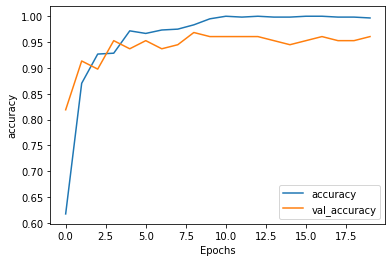

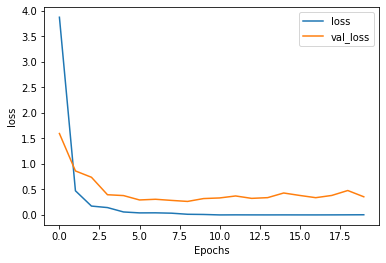

In [12]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [13]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

8/8 [==============================] - 4s 490ms/step - loss: 0.3556 - accuracy: 0.9606
Test Accuracy: 96.06%
19/19 [==============================] - 19s 984ms/step - loss: 6.9936e-04 - accuracy: 1.0000
Train Accuracy: 100.00%


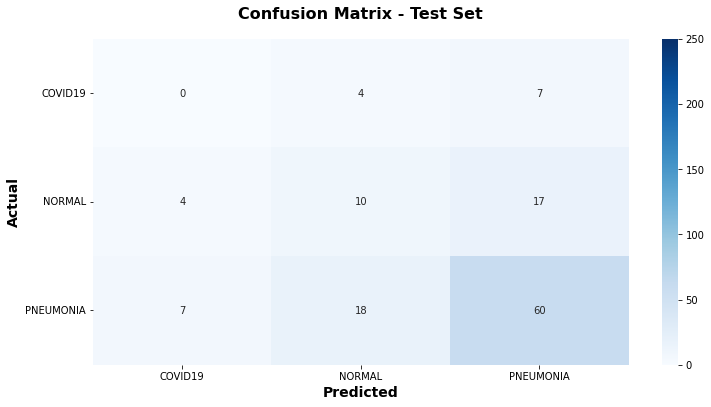

In [14]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4. Model with smaller sample size (20%)
- Training Accuracy: 100%
- Testing Accuracy: 93.39%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 99.62%
  - Testing Accuracy: 96.27%

Image Pre-processing

In [15]:
sample_train_dir = "/content/drive/My Drive/Data/unique_20_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_20_sample_test"

In [16]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=269
NORMAL=253
PNEUMONIA=683
Test set:
COVID19=23
NORMAL=63
PNEUMONIA=171
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [17]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 1205 images belonging to 3 classes.
Found 257 images belonging to 3 classes.


Model

In [18]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [19]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
# Callbacks
checkpoint = ModelCheckpoint("xception_20%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
38/38 [==============================] - 387s 10s/step - loss: 1.4792 - accuracy: 0.7867 - val_loss: 1.1713 - val_accuracy: 0.8638

Epoch 00001: val_accuracy improved from -inf to 0.86381, saving model to xception_20%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
38/38 [==============================] - 53s 1s/step - loss: 0.2353 - accuracy: 0.9046 - val_loss: 0.8163 - val_accuracy: 0.8872

Epoch 00002: val_accuracy improved from 0.86381 to 0.88716, saving model to xception_20%sample.h5
Epoch 3/20
38/38 [==============================] - 46s 1s/step - loss: 0.1596 - accuracy: 0.9237 - val_loss: 0.3614 - val_accuracy: 0.9105

Epoch 00003: val_accuracy improved from 0.88716 to 0.91051, saving model to xception_20%sample.h5
Epoch 4/20
38/38 [==============================] - 46s 1s/step - loss: 0.0867 - accuracy: 0.9461 - val_loss: 0.4214 - val_accuracy: 0.9183

Epoch 00004: val_accuracy improved from 0.91051 to 0.91829, saving model to xception_20%sample.h5
Epoch 5/20
38/38 [==============================] - 47s 1s/step - loss: 0.0453 - accuracy: 0.9602 - val_loss: 0.3091 - val_accuracy: 0.9261

Epoch 00005: val_accuracy improved from 0.91829 to 0.92607, saving model to xception_20%sample.h5
Epoch 6/20
38/38 [==========================

Model Evaluation

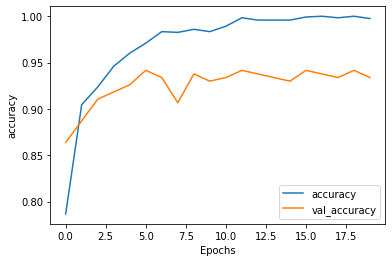

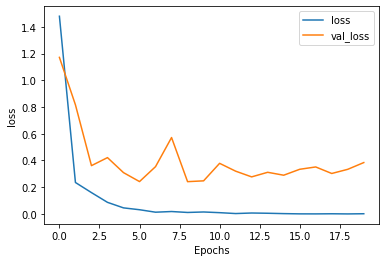

In [21]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [22]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

17/17 [==============================] - 9s 497ms/step - loss: 0.3843 - accuracy: 0.9339
Test Accuracy: 93.39%
38/38 [==============================] - 36s 950ms/step - loss: 6.2747e-04 - accuracy: 1.0000
Train Accuracy: 100.00%


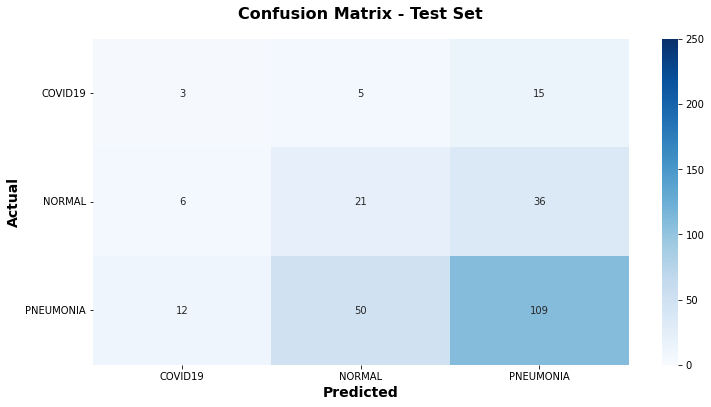

In [23]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 5. Model with smaller sample size (60%)
- Training Accuracy: 100%
- Testing Accuracy: 95.73%
- Note: Model results for that without dropout and augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 98.81%
  - Testing Accuracy: 94.69%

Image Pre-processing

In [24]:
sample_train_dir = "/content/drive/My Drive/Data/unique_60_sample_train"
sample_test_dir = "/content/drive/My Drive/Data/unique_60_sample_test"

In [25]:
print("Train set:\n========================================")
num_covid19 = len(os.listdir(os.path.join(sample_train_dir, 'COVID19')))
num_normal = len(os.listdir(os.path.join(sample_train_dir, 'NORMAL')))
num_pneumonia = len(os.listdir(os.path.join(sample_train_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19}")
print(f"NORMAL={num_normal}")
print(f"PNEUMONIA={num_pneumonia}")

print("Test set:\n========================================")
num_covid19_test = len(os.listdir(os.path.join(sample_test_dir, 'COVID19')))
num_normal_test = len(os.listdir(os.path.join(sample_test_dir, 'NORMAL')))
num_pneumonia_test = len(os.listdir(os.path.join(sample_test_dir, 'PNEUMONIA')))
print(f"COVID19={num_covid19_test}")
print(f"NORMAL={num_normal_test}")
print(f"PNEUMONIA={num_pneumonia_test}")

# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Train set:
COVID19=809
NORMAL=759
PNEUMONIA=2050
Test set:
COVID19=69
NORMAL=190
PNEUMONIA=513
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


In [26]:
img_size = 299

# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(sample_train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(sample_test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 3618 images belonging to 3 classes.
Found 772 images belonging to 3 classes.


Model

In [27]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [28]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
# Callbacks
checkpoint = ModelCheckpoint("xception_60%sample.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
114/114 [==============================] - 1102s 10s/step - loss: 0.6746 - accuracy: 0.8472 - val_loss: 0.1617 - val_accuracy: 0.9326

Epoch 00001: val_accuracy improved from -inf to 0.93264, saving model to xception_60%sample.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
114/114 [==============================] - 145s 1s/step - loss: 0.0546 - accuracy: 0.9397 - val_loss: 0.2045 - val_accuracy: 0.9275

Epoch 00002: val_accuracy did not improve from 0.93264
Epoch 3/20
114/114 [==============================] - 141s 1s/step - loss: 0.0394 - accuracy: 0.9569 - val_loss: 0.1341 - val_accuracy: 0.9534

Epoch 00003: val_accuracy improved from 0.93264 to 0.95337, saving model to xception_60%sample.h5
Epoch 4/20
114/114 [==============================] - 143s 1s/step - loss: 0.0240 - accuracy: 0.9735 - val_loss: 0.1560 - val_accuracy: 0.9417

Epoch 00004: val_accuracy did not improve from 0.95337
Epoch 5/20
114/114 [==============================] - 142s 1s/step - loss: 0.0240 - accuracy: 0.9732 - val_loss: 0.1334 - val_accuracy: 0.9598

Epoch 00005: val_accuracy improved from 0.95337 to 0.95984, saving model to xception_60%sample.h5
Epoch 6/20
114/114 [==============================] - 141s 1s/step - loss: 0.0149 - accuracy: 0.9834 - val_loss: 0.188

Model Evaluation

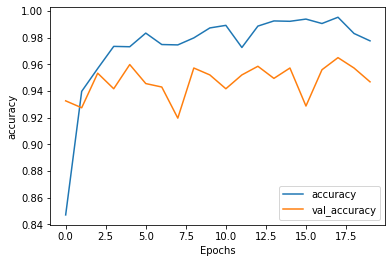

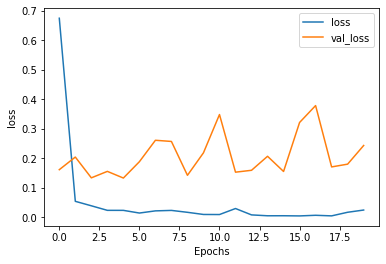

In [30]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [31]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

49/49 [==============================] - 25s 506ms/step - loss: 0.2437 - accuracy: 0.9469
Test Accuracy: 94.69%
114/114 [==============================] - 114s 999ms/step - loss: 0.0355 - accuracy: 0.9881
Train Accuracy: 98.81%


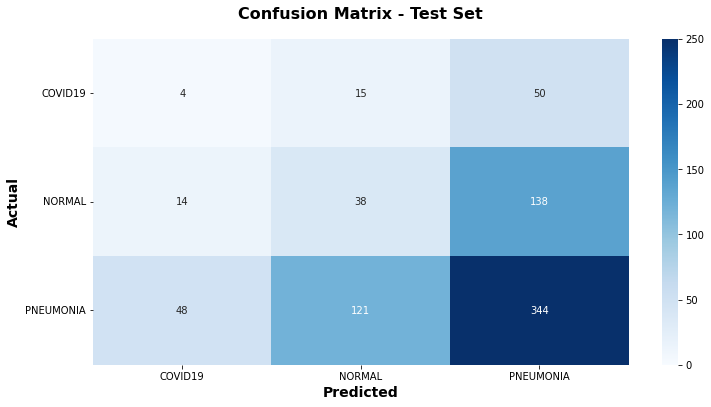

In [32]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);